In [170]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Imports

In [171]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# 1) Brief description of the problem and data

The project is about the NLP Disaster Tweet [kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview). It is stated as follows:

> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
> 
> But, it’s not always clear whether a person’s words are actually announcing a disaster.
> 
> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

The dataset is composed of approximately 10,000 tweets that have been labeled by hand. It includes information on keywords and location if available, but the most important pieces of data are the text of the tweet and the target label (1 for disaster-related tweets, 0 for all other tweets).

In [172]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 2) Exploratory Data Analysis

The initial step is to examine the dataset.

## Class balance
It is important to check that there is not a significant imbalnce in class values.

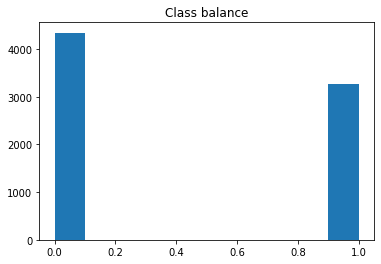

In [173]:
plt.hist(df_train['target'])
plt.title("Class balance");

The plot above shows there is a good even balance between the two class values.

## Tweet word counts
This gives an initial sense of the tweet data. We are expecting to see a normal distribution of tweet word counts.

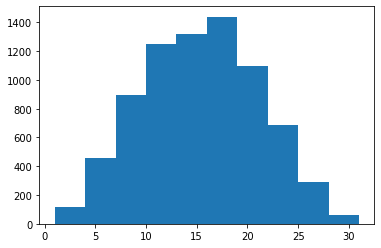

In [174]:
plt.hist(df_train['text'].str.split().apply(len));

The plot above looks good and is as expected, with the average tweet word count around 15 words.

## Tweet word frequencies
To get an intiial sense of the tweets and actual words used in the tweets labelled "disaster", lets look at  say the 200 most common words used in these tweets:

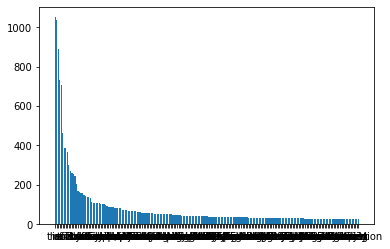

['the', 'in', 'of', 'a', 'to', 'and', '-', 'on', 'for', 'is', 'at', 'I', 'The', 'by', 'from', 'A', 'that', 'with', 'was', 'are', 'it', 'after', 'as', 'have', 'via', 'this', 'fire', 'my', 'over', '...', '&amp;', 'you', 'be', 'has', 'been', 'In', 'who', 'California', 'killed', 'like', 'an', 'people', 'up', 'than', 'when', 'not', 'but', 'suicide', 'into', 'were', 'no', '2', 'More', 'just', 'about', 'will', 'This', 'Hiroshima', 'disaster', 'Northern', 'bombing', 'bomber', 'crash', 'more', 'bomb', 'out', 'families', 'fires', 'one', 'your', 'police', 'Obama', 'buildings', 'fatal', '|', 'train', 'burning', 'so', 'me', 'all', 'off', 'Malaysia', 'News', 'near', 'they', 'we', 'nuclear', 'those', 'or', 'car', 'Police', 'had', 'To', 'get', 'dead', 'After', 'storm', "I'm", "don't", 'may', 'mass', 'RT', 'what', 'MH370:', '70', 'attack', 'Fire', 'homes', 'debris', 'collapse', 'if', 'there', 'two', 'Japan', 'From', 'Investigators', 'Two', 'years', 'how', 'down', 'Saudi', 'injured', 'do', 'old', 'Disas

In [175]:
word_freq={}
disaster_tweets = df_train["text"].loc[df_train["target"]==1]
for tweet in disaster_tweets:
    tweet_words = tweet.split()
        
    for tweet_word in tweet_words:                           
        if tweet_word in word_freq:
            word_freq[tweet_word] +=1
        else:
            word_freq[tweet_word] =1

word_freq= dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

names = list(word_freq.keys())[:200]
values = list(word_freq.values())[:200]

plt.bar(range(200), values, tick_label=names)
plt.show()

print(names)

## Stopwords

From the above output, let's select the first 26 words as obvious stopwords and remove these from the tweets in the training data. This will help the model training a great deal.

In [176]:
stopwords = ['the', 'in', 'of', 'a', 'to', 'and', '-', 'on', 'for', 'is', 'at', 'I', 'The', 'by', 
             'from', 'A', 'that', 'with', 'was', 'are', 'it', 'after', 'as', 'have', 'via', 'this']
print(stopwords)

def remove_stopwords(tweet):
    rtn=""
    for tweet_word in tweet.split():
        if tweet_word not in stopwords:
            rtn+=tweet_word + " "
    return rtn

#df_train["text"]
df_train["text"] = df_train["text"].apply(remove_stopwords)
print(df_train["text"])

['the', 'in', 'of', 'a', 'to', 'and', '-', 'on', 'for', 'is', 'at', 'I', 'The', 'by', 'from', 'A', 'that', 'with', 'was', 'are', 'it', 'after', 'as', 'have', 'via', 'this']
0       Our Deeds Reason #earthquake May ALLAH Forgive...
1                 Forest fire near La Ronge Sask. Canada 
2       All residents asked 'shelter place' being noti...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent photo Ruby #Alaska smoke #wildfi...
                              ...                        
7608    Two giant cranes holding bridge collapse into ...
7609    @aria_ahrary @TheTawniest out control wild fir...
7610    M1.94 [01:04 UTC]?5km S Volcano Hawaii. http:/...
7611    Police investigating an e-bike collided car Li...
7612    Latest: More Homes Razed Northern California W...
Name: text, Length: 7613, dtype: object


## 3) Model Architecture
Now the data is clean and well understood, we can proceed to experimenting with different model designs.

In [217]:
# Helper functions

def plot_learning_curve(hist, title):
    history = hist.history
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'])
    plt.ylim([0.6, 1.0])
    #plt.show();
    


## Training/Validation data split
Since the actual test data labels are not avialable from Kaggle, anotehr way to test the models is to split the training data into "training" and "validation". This is not problematic in this case because there is so much training data available.

In [178]:
train, valid = train_test_split(df_train, test_size=0.2)

In [179]:
# Vectorize corpus
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

N_WORDS = 2000

tok = Tokenizer(num_words = N_WORDS, oov_token = '<OOV>')
tok.fit_on_texts(df_train["text"])

train_seq = tok.texts_to_sequences(train["text"])
# The RNN requires the inputs to be of fixed length
train_pad = pad_sequences(train_seq, maxlen = 30)

valid_seq = tok.texts_to_sequences(valid["text"])
valid_pad = pad_sequences(valid_seq,  maxlen = 30)


## Model 1

There does not seem to be much agreement from anyone about how the size and order of the layers in tese perceptron models, so this is this Model 1 is a bit of an intiial stab in the dark just see if the performance (validation accuracy) is in the right ball park.

The main thing is that it contains an LTSM layer!

In [180]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model1.build(input_shape=(64, 30))
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          128000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 154,945
Trainable params: 154,945
Non-trainable params: 0
_________________________________________________________________


In [181]:
# Note the fit method also has the rather handy feature of performing the validation accuracy test as well :-)
# If not, we would need a seperate .predict step against the validation data, then calculate the model metrics.
history1 = model1.fit(train_pad,train["target"],epochs=10,validation_data=(valid_pad, valid["target"]),verbose=2)

Epoch 1/10
191/191 - 24s - loss: 0.6326 - accuracy: 0.7107 - val_loss: 0.5088 - val_accuracy: 0.7919
Epoch 2/10
191/191 - 12s - loss: 0.4319 - accuracy: 0.8350 - val_loss: 0.5049 - val_accuracy: 0.7768
Epoch 3/10
191/191 - 13s - loss: 0.3690 - accuracy: 0.8627 - val_loss: 0.7861 - val_accuracy: 0.7984
Epoch 4/10
191/191 - 13s - loss: 0.3279 - accuracy: 0.8911 - val_loss: 1.1994 - val_accuracy: 0.7919
Epoch 5/10
191/191 - 14s - loss: 0.2796 - accuracy: 0.9125 - val_loss: 1.3647 - val_accuracy: 0.7748
Epoch 6/10
191/191 - 13s - loss: 0.3214 - accuracy: 0.9023 - val_loss: 1.3426 - val_accuracy: 0.7741
Epoch 7/10
191/191 - 13s - loss: 0.4312 - accuracy: 0.8708 - val_loss: 1.1387 - val_accuracy: 0.7846
Epoch 8/10
191/191 - 14s - loss: 0.3009 - accuracy: 0.8780 - val_loss: 1.2884 - val_accuracy: 0.7761
Epoch 9/10
191/191 - 13s - loss: 0.2222 - accuracy: 0.9297 - val_loss: 1.5620 - val_accuracy: 0.7702
Epoch 10/10
191/191 - 13s - loss: 0.1880 - accuracy: 0.9491 - val_loss: 1.9954 - val_accura

In [182]:
history1.history

{'loss': [0.6326045989990234,
  0.4318786859512329,
  0.3690105378627777,
  0.3278684914112091,
  0.2796422839164734,
  0.3213764429092407,
  0.4312171936035156,
  0.3009384274482727,
  0.22222010791301727,
  0.18797411024570465],
 'accuracy': [0.7106732130050659,
  0.8349753618240356,
  0.8627257943153381,
  0.8911330103874207,
  0.9124794602394104,
  0.9022988677024841,
  0.8707717657089233,
  0.8779967427253723,
  0.9297208786010742,
  0.9490968585014343],
 'val_loss': [0.5088249444961548,
  0.5049173831939697,
  0.7860683798789978,
  1.1994189023971558,
  1.3646976947784424,
  1.3425798416137695,
  1.1386713981628418,
  1.2883528470993042,
  1.5620253086090088,
  1.9953511953353882],
 'val_accuracy': [0.7918581962585449,
  0.7767564058303833,
  0.7984241843223572,
  0.7918581962585449,
  0.7747865915298462,
  0.7741299867630005,
  0.784635603427887,
  0.7760998010635376,
  0.770190417766571,
  0.7531188726425171]}

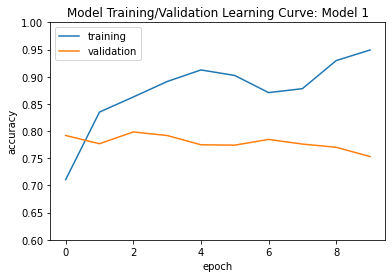

In [221]:
plot_learning_curve(history1, "Model Training/Validation Learning Curve: Model 1")

## Model 2

Add a dropout layer

In [184]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000,output_dim=128,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.75, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model2.build(input_shape=(64, 25))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 358,977
Trainable params: 358,977
Non-trainable params: 0
_________________________________________________________________


In [185]:
history2 = model2.fit(train_pad,train["target"],epochs=10, validation_data=(valid_pad, valid["target"]), verbose=2)

Epoch 1/10
191/191 - 58s - loss: 0.8878 - accuracy: 0.5954 - val_loss: 0.5859 - val_accuracy: 0.7242
Epoch 2/10
191/191 - 47s - loss: 0.5587 - accuracy: 0.7217 - val_loss: 0.4888 - val_accuracy: 0.7899
Epoch 3/10
191/191 - 48s - loss: 0.4546 - accuracy: 0.8020 - val_loss: 0.6083 - val_accuracy: 0.7991
Epoch 4/10
191/191 - 48s - loss: 0.4583 - accuracy: 0.8264 - val_loss: 0.6310 - val_accuracy: 0.7997
Epoch 5/10
191/191 - 49s - loss: 0.4268 - accuracy: 0.8366 - val_loss: 0.5672 - val_accuracy: 0.8024
Epoch 6/10
191/191 - 48s - loss: 0.4413 - accuracy: 0.8489 - val_loss: 0.5511 - val_accuracy: 0.7827
Epoch 7/10
191/191 - 49s - loss: 0.4107 - accuracy: 0.8530 - val_loss: 0.8816 - val_accuracy: 0.8004
Epoch 8/10
191/191 - 47s - loss: 0.3717 - accuracy: 0.8685 - val_loss: 0.9156 - val_accuracy: 0.7984
Epoch 9/10
191/191 - 49s - loss: 0.3792 - accuracy: 0.8847 - val_loss: 0.9255 - val_accuracy: 0.7991
Epoch 10/10
191/191 - 48s - loss: 0.3630 - accuracy: 0.8933 - val_loss: 0.9800 - val_accura

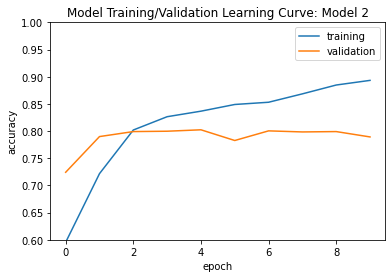

In [219]:
plot_learning_curve(history2, "Model Training/Validation Learning Curve: Model 2")

## Model 3

Same as Model 2, but with double the number of perceptrons per layer

In [187]:
model3 =  tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000,output_dim=128,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.75, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model3.build(input_shape=(64, 30))
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 535,681
Trainable params: 535,681
Non-trainable params: 0
_________________________________________________________________


In [188]:
history3 = model3.fit(train_pad,train["target"],epochs=10,validation_data=(valid_pad, valid["target"]),verbose=2)

Epoch 1/10
191/191 - 78s - loss: 0.7112 - accuracy: 0.6422 - val_loss: 0.5644 - val_accuracy: 0.7630
Epoch 2/10
191/191 - 70s - loss: 0.4918 - accuracy: 0.7755 - val_loss: 0.5159 - val_accuracy: 0.8004
Epoch 3/10
191/191 - 69s - loss: 0.4883 - accuracy: 0.7936 - val_loss: 0.5640 - val_accuracy: 0.7978
Epoch 4/10
191/191 - 69s - loss: 0.4434 - accuracy: 0.8389 - val_loss: 0.6589 - val_accuracy: 0.8004
Epoch 5/10
191/191 - 69s - loss: 0.4693 - accuracy: 0.8396 - val_loss: 0.9403 - val_accuracy: 0.7925
Epoch 6/10
191/191 - 71s - loss: 0.3856 - accuracy: 0.8499 - val_loss: 0.6389 - val_accuracy: 0.7965
Epoch 7/10
191/191 - 74s - loss: 0.4832 - accuracy: 0.7956 - val_loss: 0.6169 - val_accuracy: 0.7919
Epoch 8/10
191/191 - 76s - loss: 0.4116 - accuracy: 0.8461 - val_loss: 0.6866 - val_accuracy: 0.7945
Epoch 9/10
191/191 - 82s - loss: 0.3772 - accuracy: 0.8650 - val_loss: 0.8050 - val_accuracy: 0.7919
Epoch 10/10
191/191 - 82s - loss: 0.3861 - accuracy: 0.8695 - val_loss: 0.6566 - val_accura

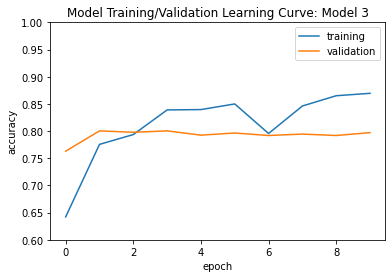

In [220]:
plot_learning_curve(history3, "Model Training/Validation Learning Curve: Model 3")

# 5) Prediction and Conclusion

From the three models below, there isnt that much difference between all three models, with all of them capaple of acheiving around an 80% accuracy. This validation score of 80% was also my Kaggle leaderboard score.

I have no doubt that much better models coud be developed using these neural networks, but it is a very time consuming business waiting for the models to build each time, and these is a nearly infinite number of ways the various layer types and layer sizes can be pieced together.

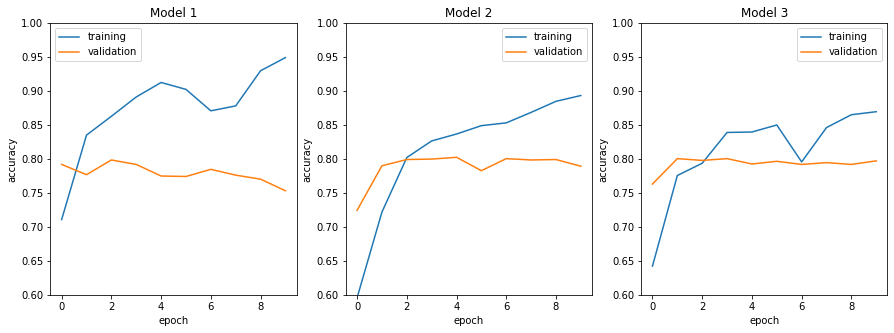

In [222]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_learning_curve(history1, "Model 1")
plt.subplot(1, 3, 2)
plot_learning_curve(history2, "Model 2")
plt.subplot(1, 3, 3)
plot_learning_curve(history3, "Model 3")
#plt.tight_layout()
plt.show()

Finally, use one of the models to predict the outputs from the Kaggle test data, and upload to Kaggle as file "submission.csv"

In [ ]:
# Read in the Kaggle test data
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_seq = tok.texts_to_sequences(test["text"])
test_pad = pad_sequences(test_seq, maxlen = 30)
# Use model 3 to make predictions on the Kaggle test data
preds = model3.predict(test_pad)
df_sub = pd.DataFrame()
df_sub['id'] = test['id']
# Convert the model outputs to labels "0" or "1" using a 0.5 threshold
df_sub['target'] = list(map(lambda x: 0 if x < 0.5 else 1, preds))
df_sub.to_csv('submission.csv', index=False)